In [1]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = cupy


In [3]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.68 μs


((10000, 3), (2000, 3))

In [4]:
df_train_images.head()

,index,value,png
image_id,,,
27456,0,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50770,1,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
9353,2,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50328,3,0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
18785,4,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [6]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [7]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


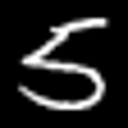
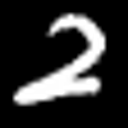
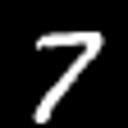
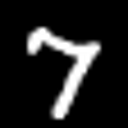
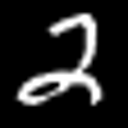
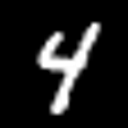
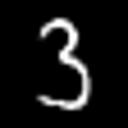
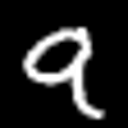
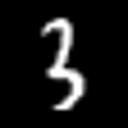
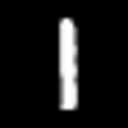
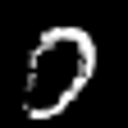
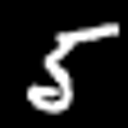
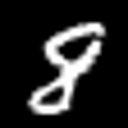
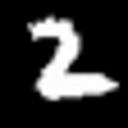
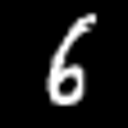
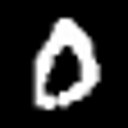

In [8]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [9]:
#COS_SIM_THRESHOLD = 0.075
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, np)

In [10]:
class CorticalColumn(object):
    def __init__(self):
        self.clusters = defaultdict(list) # cluster = collection of image bundles for particular class
        self.cluster_norms = HdvArray(hdc.N, xp)
        self.cluster_to_image_ids = defaultdict(set)

In [11]:
COLUMN = CorticalColumn()

In [12]:
# Есть ли вложенность/пересечения в кластерах???
for i, image_ids_i in COLUMN.cluster_to_image_ids.items():
    for j, image_ids_j in COLUMN.cluster_to_image_ids.items():
        if i == j:
            continue

        if image_ids_i.issubset(image_ids_j):
            print(f'{i} is a subset of {j}')

        z = image_ids_i.intersection(image_ids_j)

        if z:
            print(f'{i} & {j} -> {z}')


In [18]:
COLUMN = CorticalColumn()
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])
df_conso_progress = pd.DataFrame(columns=['trial', 'stage', 'cluster_id', 'len'])

trials = 10
count = 1000

for trial in tqdm(range(trials)):
    # TRAIN STEP
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(train_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
        image_bundle = hdc.bundle(image_encoding_hdvs)
        image_bundle_norm = hdc.normalize(image_bundle)
        image_bundle_norm = xp_array_to_gpu(image_bundle_norm)
        cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
        cos_sims_indices = xp.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
        sorted_cos_sims_with_indices = sorted(zip(cos_sims[cos_sims_indices], cos_sims_indices), key=lambda x: -x[0]) # sort by cos sim desc

        # Debundle from ALL clusters which showed similarity but actually are not
        for _, index in sorted_cos_sims_with_indices:
            index = int(index) # needed if cupy is used (otherwise error about unhashable type)
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value != image_value:
                similar_cluster.append(hdc.complement(image_bundle))
                COLUMN.cluster_norms.array[index] = xp_array_to_gpu(hdc.normalize(hdc.bundle(similar_cluster)))

        # Bundle with MOST successive one
        for _, index in sorted_cos_sims_with_indices:
            index = int(index) # needed if cupy is used (otherwise error about unhashable type)
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value == image_value:
                similar_cluster_image_ids.add(image_id)
                similar_cluster.append(image_bundle)
                COLUMN.cluster_norms.array[index] = xp_array_to_gpu(hdc.normalize(hdc.bundle(similar_cluster)))

        # Recheck if recognition for given image is Ok
        cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
        max_cos_sim_index = int(xp.argmax(cos_sims))

        for _ in range(1):
            if cos_sims[max_cos_sim_index] >= COS_SIM_THRESHOLD:
                similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
                assert len(similar_cluster_image_ids) > 0
                similar_cluster_image_id = next(iter(similar_cluster_image_ids))
                similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

                if similar_cluster_image_value == image_value:
                    break # Correct match found, relax outselves!
        else:
            # Didn't find any matching cluster of HDVs to join -> create new one
            index = COLUMN.cluster_norms.lease()
            COLUMN.cluster_norms.array[index] = image_bundle_norm
            COLUMN.clusters[index].append(image_bundle)
            COLUMN.cluster_to_image_ids[index].add(image_id)

    # CONSOLIDATE MEMORY
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        df_conso_progress.loc[len(df_conso_progress)] = [trial, 'before', cluster_index, len(image_ids)]
    
    before_len = COLUMN.cluster_norms.len()
    assert before_len == len(COLUMN.clusters)
    cluster_indices_to_release = []
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        l = 1
        exp_distro_level = l * np.exp(-l * len(image_ids))
        rand_level = RNG.random()
        do_release = rand_level < exp_distro_level
        
        if do_release:
            cluster_indices_to_release.append(cluster_index)

    for cluster_index_to_release in cluster_indices_to_release:
        del COLUMN.clusters[cluster_index_to_release]
        del COLUMN.cluster_to_image_ids[cluster_index_to_release]
        COLUMN.cluster_norms.release(cluster_index_to_release)

    after_len = COLUMN.cluster_norms.len()
    assert after_len == len(COLUMN.clusters)
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        df_conso_progress.loc[len(df_conso_progress)] = [trial, 'after', cluster_index, len(image_ids)]

    # INFER STEP
    inference_count = 0
    correct_inference_count = 0
    infer_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(infer_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encoding_hdvs = map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv'])

        for image_encoding_hdv in image_encoding_hdvs:
            image_encoding_hdv_norm = hdc.normalize(image_encoding_hdv)
            image_encoding_hdv_norm = xp_array_to_gpu(image_encoding_hdv_norm)
            cos_sims = COLUMN.cluster_norms.array @ image_encoding_hdv_norm
            max_cos_sim_index = int(xp.argmax(cos_sims))
    
            if cos_sims[max_cos_sim_index] < COS_SIM_THRESHOLD:
                continue
                
            inference_count += 1
    
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids))
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']
            
            is_correct_infer = similar_cluster_image_value == image_value
            correct_inference_count += int(is_correct_infer)
            break
        
    df_train_progress.loc[len(df_train_progress)] = [count, inference_count, correct_inference_count]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

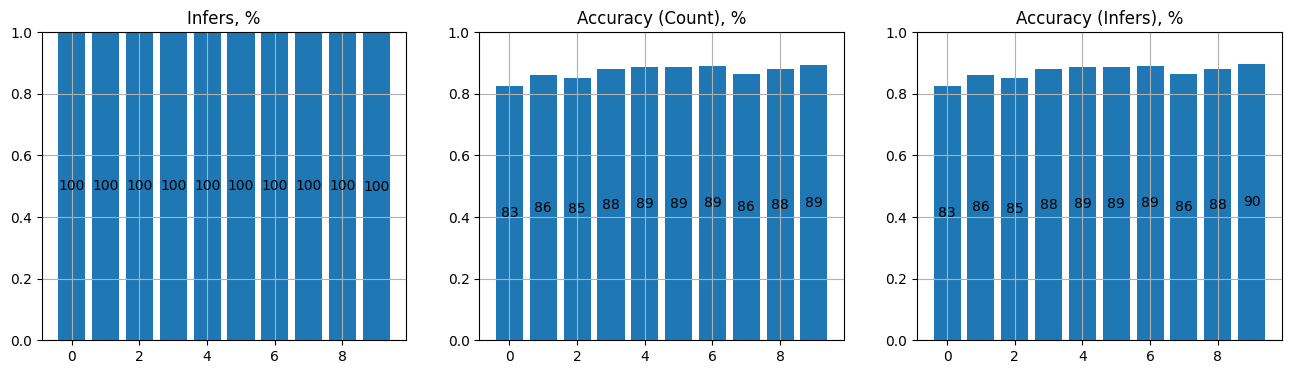

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
0,1000,999,826,0.999,0.826,0.826827
1,1000,999,862,0.999,0.862,0.862863
2,1000,1000,850,1.000,0.850,0.850000
3,1000,1000,881,1.000,0.881,0.881000
4,1000,999,886,0.999,0.886,0.886887
5,1000,999,887,0.999,0.887,0.887888
6,1000,1000,891,1.000,0.891,0.891000
7,1000,999,863,0.999,0.863,0.863864
8,1000,1000,881,1.000,0.881,0.881000
9,1000,998,894,0.998,0.894,0.895792


In [19]:
df_train_progress2 = df_train_progress.copy()
df_train_progress2['infer_ratio'] = df_train_progress2['infers'] / df_train_progress2['count']
df_train_progress2['accuracy_count'] = df_train_progress2['correct_infers'] / df_train_progress2['count']
df_train_progress2['accuracy_infers'] = df_train_progress2['correct_infers'] / df_train_progress2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.grid()

plt.show()
df_train_progress2


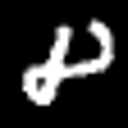

In [40]:
images = []
captions = []

if COLUMN.clusters.keys():
    random_cluster_i = RNG.choice(list(COLUMN.clusters.keys()))
    image_ids = COLUMN.cluster_to_image_ids[random_cluster_i]
    df_i = df_train_images.loc[list(image_ids)]
    image_datas = df_i['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    captions = list(map(lambda p: f'clust={random_cluster_i}, #{p[0]}, val={p[1]}', zip(df_i.index, df_i['value'])))
    
display_images_grid(images, captions=captions, col_count=8)

In [146]:
count = 2000
df_test_results = pd.DataFrame(columns=['test_image_id', 'true_value', 'cluster_id', 'infer_value', 'sim'])
test_image_ids = RNG.choice(df_test_images.index.unique(), count, replace=False)
#test_image_ids = [100007372]
inference_count = 0
correct_inference_count = 0

for image_id in tqdm(test_image_ids, leave=False):
    image_value = df_test_images.loc[image_id]['value']
    df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=test_db_con)
    assert len(df_image_encodings) > 0
    image_encoding_hdvs = map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv'])
    max_cos_sim_index = -1 # aka cluster id
    max_similar_cluster_image_value = ''
    max_cos_sim = 0

    for image_encoding_hdv in image_encoding_hdvs:
        image_encoding_hdv_norm = hdc.normalize(image_encoding_hdv)
        image_encoding_hdv_norm = xp_array_to_gpu(image_encoding_hdv_norm)
        cos_sims = COLUMN.cluster_norms.array @ image_encoding_hdv_norm
        this_max_cos_sim_index = int(xp.argmax(cos_sims))
        this_max_cos_sim = xp_array_from_gpu(cos_sims[this_max_cos_sim_index])

        if cos_sims[this_max_cos_sim_index] < COS_SIM_THRESHOLD:
            continue

        if this_max_cos_sim > max_cos_sim:
            max_cos_sim = this_max_cos_sim
            max_cos_sim_index = this_max_cos_sim_index
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids))
            max_similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    
    df_test_results.loc[len(df_test_results)] = [image_id, image_value, max_cos_sim_index, max_similar_cluster_image_value, max_cos_sim]

df_test_results['is_correct_infer'] = df_test_results['true_value'] == df_test_results['infer_value']

  0%|          | 0/2000 [00:00<?, ?it/s]

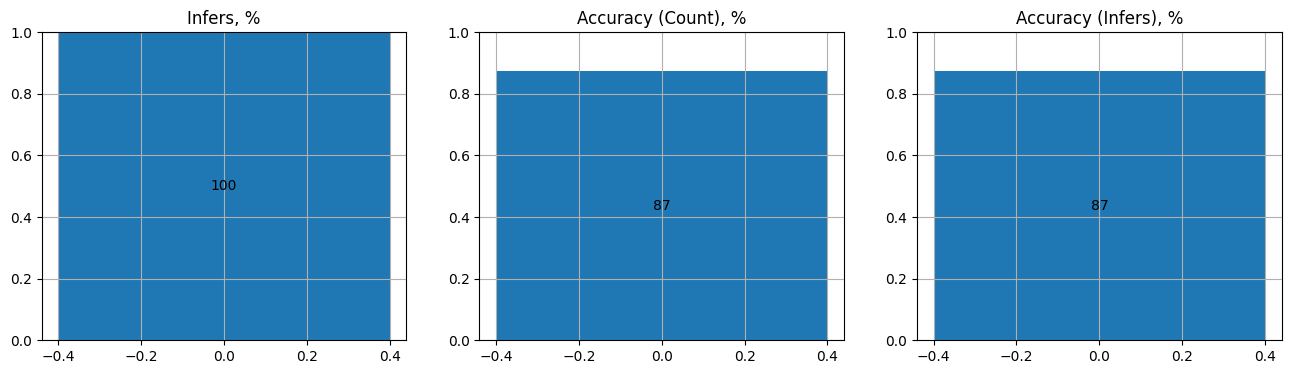

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
0,2000,1999,1747,0.9995,0.8735,0.873937


In [147]:
infers_count = (df_test_results['cluster_id'] > -1).sum()
correct_infers_count = (df_test_results['true_value'] == df_test_results['infer_value']).sum()
df_test_progress2 = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])
df_test_progress2.loc[len(df_test_progress2)] = [len(df_test_results), infers_count, correct_infers_count]
df_test_progress2['infer_ratio'] = df_test_progress2['infers'] / df_test_progress2['count']
df_test_progress2['accuracy_count'] = df_test_progress2['correct_infers'] / df_test_progress2['count']
df_test_progress2['accuracy_infers'] = df_test_progress2['correct_infers'] / df_test_progress2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(df_test_progress2.index), list(df_test_progress2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_progress2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(df_test_progress2.index), list(df_test_progress2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_progress2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(df_test_progress2.index), list(df_test_progress2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_progress2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.grid()

plt.show()
df_test_progress2

In [132]:
pd.pivot_table(df_test_results, index='true_value', columns=['is_correct_infer'], values=['test_image_id'], aggfunc=['count'])

count      
                 test_image_id      
is_correct_infer         False True 
true_value                          
0                           15   176
1                           11   219
2                           41   169
3                           20   187
4                           33   148
5                           42   135
6                           18   182
7                           26   191
8                           44   147
9                           35   161

In [155]:
df_test_results_incorrect_infers = df_test_results[df_test_results['is_correct_infer'] == False]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
incorrect_infer_image_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_image_id']
incorrect_infer_cluster_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['cluster_id']
image_data = df_test_images.loc[incorrect_infer_image_id]['png']
image_value = df_test_images.loc[incorrect_infer_image_id]['value']

df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_db_con)
assert len(df_image_encodings) > 0
image_encoding_hdvs = map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv'])
df_x = pd.DataFrame(columns=['true_value', 'cluster_id', 'cluster_value', 'sim'])

for image_encoding_hdv in image_encoding_hdvs:
    image_encoding_hdv_norm = hdc.normalize(image_encoding_hdv)
    image_encoding_hdv_norm = xp_array_to_gpu(image_encoding_hdv_norm)
    cos_sims = COLUMN.cluster_norms.array @ image_encoding_hdv_norm
    max_cos_sim_index = int(xp.argmax(cos_sims))
    max_cos_sim = xp_array_from_gpu(cos_sims[max_cos_sim_index])

    if cos_sims[max_cos_sim_index] < COS_SIM_THRESHOLD:
        continue

    similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
    assert len(similar_cluster_image_ids) > 0
    similar_cluster_image_id = next(iter(similar_cluster_image_ids))
    similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    df_x.loc[len(df_x)] = [image_value, max_cos_sim_index, similar_cluster_image_value, max_cos_sim]

df_x.sort_values(by='sim', ascending=False)

,true_value,cluster_id,cluster_value,sim
6,6,226,0,0.10350888834976019
15,6,130,6,0.09287200673449468
5,6,12,6,0.08926529383207574
33,6,232,6,0.08635677829726608
16,6,170,6,0.08443675483565317
26,6,171,6,0.08333344602688733
19,6,273,6,0.08231992868857155
32,6,273,6,0.08171938005849835
31,6,22,6,0.0798158169628589
28,6,12,6,0.07901419290159742


In [136]:
df_test_results.loc[incorrect_infer_row_index]

test_image_id                 100007372
true_value                            5
cluster_id                           70
infer_value                           3
sim                 0.07236942128898642
is_correct_infer                  False
Name: 1983, dtype: object